In [1]:

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import tensorflow as tf

In [2]:
import pickle

def load_pickled_data(file, columns):
    """
    Loads pickled training and test data.
    
    Parameters
    ----------
    file    : 
              Name of the pickle file.
    columns : list of strings
              List of columns in pickled data we're interested in.

    Returns
    -------
    A tuple of datasets for given columns.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    return tuple(map(lambda c: dataset[c], columns))

In [24]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]
train_dataset_file = "data/train.p"
test_dataset_file = "data/test.p"
#train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
X_test, y_test = load_pickled_data(test_dataset_file, ['features', 'labels'])

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(y_train.shape)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(39209,)


In [4]:
import sys
import time

def get_time_hhmmss(start = None):
    """
    Calculates time since `start` and formats as a string.
    """
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str   

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [5]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings 

num_classes = 43

def preprocess_dataset(X, y = None, shuffle=True):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    Assumes original dataset is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Dataset array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing dataset with {} examples:".format(X.shape[0]))

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(num_classes)[y]
        if shuffle:
            X, y = shuffle(X, y)


    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_process_data(pickled_data_file):
    """
    Loads pickled data and preprocesses images and labels by scaling features, 
    shuffling the data and applying one-hot encoding to labels.
    
    Parameters
    ----------
    pickled_data_file  : string
                         Pickled data file name.
    Returns
    -------
    A tuple of X and y containing preloaded and preprocessed features and labels respectively.    
    """
    X, y = load_pickled_data(pickled_data_file, columns = ['features', 'labels'])
    X, y = preprocess_dataset(X, y)
    return (X, y)

In [6]:

from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import random

class AugmentedSignsBatchIterator(BatchIterator):
    """
    Iterates over dataset in batches. 
    Allows images augmentation by randomly rotating, applying projection, 
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """
        
    def __init__(self, batch_size, shuffle = False, seed = 42, p = 0.5, intensity = 0.5):
        """
        Initialises an instance with usual iterating settings, as well as data augmentation coverage
        and augmentation intensity.
        
        Parameters
        ----------
        batch_size:
                    Size of the iteration batch.
        shuffle   :
                    Flag indicating if we need to shuffle the data.
        seed      :
                    Random seed.
        p         :
                    Probability of augmenting a single example, should be in a range of [0, 1] .
                    Defines data augmentation coverage.
        intensity :
                    Augmentation intensity, should be in a [0, 1] range.
        
        Returns
        -------
        New batch iterator instance.
        """
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            yb
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)

        return Xb, yb
        
    def rotate(self, Xb, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 30. * self.intensity # scale by self.intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        depending on the size of the image. Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

        return Xb

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\wasta\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


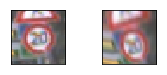

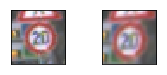

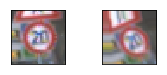

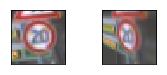

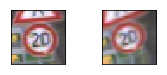

In [7]:
X_train, y_train = load_pickled_data("data/train.p", columns = ['features', 'labels'])
X_train = X_train / 255.

batch_iterator = AugmentedSignsBatchIterator(batch_size = 5, p = 1.0, intensity = 0.75)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(5): 
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i])
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i])
        pyplot.show()
    break

In [8]:
def flip_extend(X, y):
    """
    Extends existing images dataset by flipping images of some classes. As some images would still belong
    to same class after flipping we extend such classes with flipped images. Images of other would toggle 
    between two classes when flipped, so for those we extend existing datasets as well.
    
    Parameters
    ----------
    X       : ndarray
              Dataset array containing feature examples.
    y       : ndarray, optional, defaults to `None`
              Dataset labels in index form.

    Returns
    -------
    A tuple of X and y.    
    """
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

def extend_balancing_classes(X, y, aug_intensity = 0.5, counts = None):
    """
    Extends dataset by duplicating existing images while applying data augmentation pipeline.
    Number of generated examples for each class may be provided in `counts`.
    
    Parameters
    ----------
    X             : ndarray
                    Dataset array containing feature examples.
    y             : ndarray, optional, defaults to `None`
                    Dataset labels in index form.
    aug_intensity :
                    Intensity of augmentation, must be in [0, 1] range.
    counts        :
                    Number of elements for each class.
                    
    Returns
    -------
    A tuple of X and y.    
    """
    num_classes = 43

    _, class_counts = np.unique(y, return_counts = True)
    max_c = max(class_counts)
    total = max_c * num_classes if counts is None else np.sum(counts)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = np.float32)
    y_extended = np.empty([0], dtype = y.dtype)
    print("Extending dataset using augmented data (intensity = {}):".format(aug_intensity))
    
    for c, c_count in zip(range(num_classes), class_counts):
        # How many examples should there be eventually for this class:
        max_c = max_c if counts is None else counts[c]
        # First copy existing data for this class
        X_source = (X[y == c] / 255.).astype(np.float32)
        y_source = y[y == c]
        X_extended = np.append(X_extended, X_source, axis = 0)
        for i in range((max_c // c_count) - 1):
            batch_iterator = AugmentedSignsBatchIterator(batch_size = X_source.shape[0], p = 1.0, intensity = aug_intensity)
            for x_batch, _ in batch_iterator(X_source, y_source):
                X_extended = np.append(X_extended, x_batch, axis = 0)
                print_progress(X_extended.shape[0], total)
        batch_iterator = AugmentedSignsBatchIterator(batch_size = max_c % c_count, p = 1.0, intensity = aug_intensity)
        for x_batch, _ in batch_iterator(X_source, y_source):
            X_extended = np.append(X_extended, x_batch, axis = 0)
            print_progress(X_extended.shape[0], total)
            break
        # Fill labels for added images set to current class.
        added = X_extended.shape[0] - y_extended.shape[0]
        y_extended = np.append(y_extended, np.full((added), c, dtype = int))
        
    return ((X_extended * 255.).astype(np.uint8), y_extended)

In [9]:
from collections import namedtuple

Parameters = namedtuple('Parameters', [
        # Data parameters
        'num_classes', 'image_size', 
        # Training parameters
        'batch_size', 'max_epochs', 'log_epoch', 'print_epoch',
        # Optimisations
        'learning_rate_decay', 'learning_rate',
        'l2_reg_enabled', 'l2_lambda', 
        'early_stopping_enabled', 'early_stopping_patience', 
        'resume_training', 
        # Layers architecture
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'conv3_k', 'conv3_d', 'conv3_p', 
        'fc4_size', 'fc4_p'
    ])

In [10]:
import os

class Paths(object):
    """
    Provides easy access to common paths we use for persisting 
    the data associated with model training.
    """
    
    def __init__(self, params):
        """
        Initialises a new `Paths` instance and creates corresponding folders if needed.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
        """
        self.model_name = self.get_model_name(params)
        self.var_scope = self.get_variables_scope(params)
        self.root_path = os.getcwd() + "/models/" + self.model_name + "/"
        self.model_path = self.get_model_path()
        self.train_history_path = self.get_train_history_path()
        self.learning_curves_path = self.get_learning_curves_path()
        os.makedirs(self.root_path, exist_ok = True)

    def get_model_name(self, params):
        """
        Generates a model name with some of the crucial model parameters encoded into the name.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Model name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        model_name = "k{}d{}p{}_k{}d{}p{}_k{}d{}p{}_fc{}p{}".format(
            params.conv1_k, params.conv1_d, params.conv1_p, 
            params.conv2_k, params.conv2_d, params.conv2_p, 
            params.conv3_k, params.conv3_d, params.conv3_p, 
            params.fc4_size, params.fc4_p
        )
        model_name += "_lrdec" if params.learning_rate_decay else "_no-lrdec"
        model_name += "_l2" if params.l2_reg_enabled else "_no-l2"
        return model_name

    def get_variables_scope(self, params):
        """
        Generates a model variable scope with some of the crucial model parameters encoded.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Variables scope name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        var_scope = "k{}d{}_k{}d{}_k{}d{}_fc{}_fc0".format(
            params.conv1_k, params.conv1_d,
            params.conv2_k, params.conv2_d,
            params.conv3_k, params.conv3_d, 
            params.fc4_size
        )
        return var_scope

    def get_model_path(self):
        """
        Generates path to the model file.
   
        Returns
        -------
        Model file path.
        """
        return self.root_path + "model.ckpt"

    def get_train_history_path(self):
        """
        Generates path to the train history file.
   
        Returns
        -------
        Train history file path.
        """
        return self.root_path + "train_history"
    
    def get_learning_curves_path(self):
        """
        Generates path to the learning curves graph file.
   
        Returns
        -------
        Learning curves file path.
        """
        return self.root_path + "learning_curves.png"

In [11]:
class EarlyStopping(object):
    """
    Provides early stopping functionality. Keeps track of model accuracy, 
    and if it doesn't improve over time restores last best performing 
    parameters.
    """
    
    def __init__(self, saver, session, patience = 100, minimize = True):
        """
        Initialises a `EarlyStopping` isntance.

        Parameters
        ----------
        saver     : 
                    TensorFlow Saver object to be used for saving and restoring model.
        session   : 
                    TensorFlow Session object containing graph where model is restored.
        patience  : 
                    Early stopping patience. This is the number of epochs we wait for 
                    accuracy to start improving again before stopping and restoring 
                    previous best performing parameters.
                  
        Returns
        -------
        New instance.
        """
        self.minimize = minimize
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_epoch = 0
        self.restore_path = None

    def __call__(self, value, epoch):
        """
        Checks if we need to stop and restores the last well performing values if we do.

        Parameters
        ----------
        value     : 
                    Last epoch monitored value.
        epoch     : 
                    Last epoch number.
                  
        Returns
        -------
        `True` if we waited enough and it's time to stop and we restored the 
        best performing weights, or `False` otherwise.
        """
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

In [12]:
from cloudlog import CloudLog

class ModelCloudLog(CloudLog):
        
    def log_parameters(self, params, train_size, valid_size, test_size):
        """
        Logs model parameters to console and appends the same text representation to the log file.

        Parameters
        ----------
        params    : Parameters
                    Structure (`namedtuple`) containing model parameters.
        train_size: int
                    Size of the training dataset.
        valid_size: int
                    Size of the training dataset.
        test_size : int
                    Size of the training dataset.
        """
        if params.resume_training:
            self("=============================================")
            self("============= RESUMING TRAINING =============")
            self("=============================================")

        self("=================== DATA ====================")
        self("            Training set: {} examples".format(train_size))
        self("          Validation set: {} examples".format(valid_size))
        self("             Testing set: {} examples".format(test_size))
        self("              Batch size: {}".format(params.batch_size))   

        self("=================== MODEL ===================")
        self("--------------- ARCHITECTURE ----------------")  
        self(" %-*s %-*s %-*s %-*s" % (10, "", 10, "Type", 8, "Size", 15, "Dropout (keep p)"))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 1", 10, "{}x{} Conv".format(params.conv1_k, params.conv1_k), 8, str(params.conv1_d), 15, str(params.conv1_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 2", 10, "{}x{} Conv".format(params.conv2_k, params.conv2_k), 8, str(params.conv2_d), 15, str(params.conv2_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 3", 10, "{}x{} Conv".format(params.conv3_k, params.conv3_k), 8, str(params.conv3_d), 15, str(params.conv3_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 4", 10, "FC", 8, str(params.fc4_size), 15, str(params.fc4_p)))    
        self("---------------- PARAMETERS -----------------")
        self("     Learning rate decay: " + ("Enabled" if params.learning_rate_decay else "Disabled (rate = {})".format(params.learning_rate)))
        self("       L2 Regularization: " + ("Enabled (lambda = {})".format(params.l2_lambda) if params.l2_reg_enabled else "Disabled"))
        self("          Early stopping: " + ("Enabled (patience = {})".format(params.early_stopping_patience) if params.early_stopping_enabled else "Disabled"))
        self(" Keep training old model: " + ("Enabled" if params.resume_training else "Disabled"))

In [13]:
def fully_connected(input, size):
    """
    Performs a single fully connected layer pass, e.g. returns `input * weights + bias`.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    return tf.nn.relu(fully_connected(input, size))

def conv_relu(input, kernel_size, depth):
    """
    Performs a single convolution layer pass.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

def pool(input, size):
    """
    Performs a max pooling layer pass.
    """
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )

def model_pass(input, params, is_training):
    """
    Performs a full model pass.
    
    Parameters
    ----------
    input         : Tensor
                    NumPy array containing a batch of examples.
    params        : Parameters
                    Structure (`namedtuple`) containing model parameters.
    is_training   : Tensor of type tf.bool
                    Flag indicating if we are training or not (e.g. whether to use dropout).
                    
    Returns
    -------
    Tensor with predicted logits.
    """
    # Convolutions

    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = params.conv1_k, depth = params.conv1_d) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        pool1 = tf.cond(is_training, lambda: tf.nn.dropout(pool1, keep_prob = params.conv1_p), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = params.conv2_k, depth = params.conv2_d)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        pool2 = tf.cond(is_training, lambda: tf.nn.dropout(pool2, keep_prob = params.conv2_p), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = params.conv3_k, depth = params.conv3_d)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        pool3 = tf.cond(is_training, lambda: tf.nn.dropout(pool3, keep_prob = params.conv3_p), lambda: pool3)
    
    # Fully connected
    
    # 1st stage output
    pool1 = pool(pool1, size = 4)
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output
    pool2 = pool(pool2, size = 2)
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])    
    
    # 3rd stage output
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    flattened = tf.concat([pool1, pool2, pool3],1)
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = params.fc4_size)
        fc4 = tf.cond(is_training, lambda: tf.nn.dropout(fc4, keep_prob = params.fc4_p), lambda: fc4)
    with tf.variable_scope('out'):
        logits = fully_connected(fc4, size = params.num_classes)
    return logits

In [14]:
def plot_curve(axis, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots a pair of validation and training curves on a single plot.
    """
    model_history = np.load(Paths(params).train_history_path + ".npz")
    train_values = model_history[train_column]
    valid_values = model_history[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return epochs

# Plots history of learning curves for a specific model.
def plot_learning_curves(params):
    """
    Plots learning curves (loss and accuracy on both training and validation sets) for a model identified by a parameters struct.
    """
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_accuracy_history", valid_column = "valid_accuracy_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    pyplot.ylim(50., 115.)
    pyplot.xlim(0, epochs_plotted)

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_loss_history", valid_column = "valid_loss_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(0.0001, 10.)
    pyplot.xlim(0, epochs_plotted)
    pyplot.yscale("log")

In [15]:
def train_model(params, X_train, y_train, X_valid, y_valid, X_test, y_test):
    """
    Performs model training based on provided training dataset 
    according to provided parameters, and then evaluates trained 
    model with testing dataset. 
    Part of the training dataset may be used for validation during
    training if specified in model parameters.

    Parameters
    ----------
    params        : Parameters
                    Structure (`namedtuple`) containing model parameters.
    X_train       : 
                    Training dataset. 
    y_train       : 
                    Training dataset labels. 
    X_valid       : 
                    Validation dataset. 
    y_valid       : 
                    Validation dataset labels. 
    X_test        : 
                    Testing dataset. 
    y_test        : 
                    Testing dataset labels. 
    logger_config : 
                    Logger configuration, containing Dropbox and Telegram settings 
                    for notifications and cloud logs backup. 
    """
    
    # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    log = ModelCloudLog(
        os.path.join(paths.root_path, "logs"), 
    )
    start = time.time()
    model_variable_scope = paths.var_scope

    log.log_parameters(params, y_train.shape[0], y_valid.shape[0], y_test.shape[0]) 
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, params.num_classes))
        is_training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0, trainable=False)  # count the number of epochs

        # Model parameters.
        if params.learning_rate_decay:
            learning_rate = tf.train.exponential_decay(params.learning_rate, current_epoch, decay_steps = params.max_epochs, decay_rate = 0.01)
        else:
            learning_rate = params.learning_rate
            
        # Training computation.
        with tf.variable_scope(model_variable_scope):
            logits = model_pass(tf_x_batch, params, is_training)
            if params.l2_reg_enabled:
                with tf.variable_scope('fc4', reuse = True):
                    l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))
            else:
                l2_loss = 0

        predictions = tf.nn.softmax(logits)
        softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_y_batch)
        loss = tf.reduce_mean(softmax_cross_entropy) + params.l2_lambda * l2_loss  

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(loss)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        # A routine for evaluating current model parameters
        def get_accuracy_and_loss_in_batches(X, y):
            p = []
            sce = []
            batch_iterator = BatchIterator(batch_size = 128)
            for x_batch, y_batch in batch_iterator(X, y):
                [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : False
                    }
                )
                p.extend(p_batch)
                sce.extend(sce_batch)
            p = np.array(p)
            sce = np.array(sce)
            accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
            loss = np.mean(sce)
            return (accuracy, loss)
        
        # If we chose to keep training previously trained model, restore session.
        if params.resume_training: 
            try:
                tf.train.Saver().restore(session, paths.model_path)
            except Exception as e:
                log("Failed restoring previously trained model: file does not exist.")
                pass
        
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(tf.train.Saver(), session, patience = params.early_stopping_patience, minimize = True)
        train_loss_history = np.empty([0], dtype = np.float32)
        train_accuracy_history = np.empty([0], dtype = np.float32)
        valid_loss_history = np.empty([0], dtype = np.float32)
        valid_accuracy_history = np.empty([0], dtype = np.float32)
        if params.max_epochs > 0:
            log("================= TRAINING ==================")
        else:
            log("================== TESTING ==================")       
        log(" Timestamp: " + get_time_hhmmss())
        log.sync()
        
        for epoch in range(params.max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = BatchIterator(batch_size = params.batch_size, shuffle = True)
            for x_batch, y_batch in batch_iterator(X_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            # If another significant epoch ended, we log our losses.
            if (epoch % params.log_epoch == 0):
                # Get validation data predictions and log validation loss:
                valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)

                # Get training data predictions and log training loss:
                train_accuracy, train_loss = get_accuracy_and_loss_in_batches(X_train, y_train)

                if (epoch % params.print_epoch == 0):
                    log("-------------- EPOCH %4d/%d --------------" % (epoch, params.max_epochs))
                    log("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                    log("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                    log("      Best loss: %.8f at epoch %d" % (early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                    log("   Elapsed time: " + get_time_hhmmss(start))
                    log("      Timestamp: " + get_time_hhmmss())
                    log.sync()
            else:
                valid_loss = 0.
                valid_accuracy = 0.
                train_loss = 0.
                train_accuracy = 0.
                
            valid_loss_history = np.append(valid_loss_history, [valid_loss])
            valid_accuracy_history = np.append(valid_accuracy_history, [valid_accuracy])
            train_loss_history = np.append(train_loss_history, [train_loss])
            train_accuracy_history = np.append(train_accuracy_history, [train_accuracy])
            
            if params.early_stopping_enabled:
                # Get validation data predictions and log validation loss:
                if valid_loss == 0:
                    _, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
                if early_stopping(valid_loss, epoch): 
                    log("Early stopping.\nBest monitored loss was {:.8f} at epoch {}.".format(
                        early_stopping.best_monitored_value, early_stopping.best_monitored_epoch
                    ))
                    break

        # Evaluate on test dataset.
        test_accuracy, test_loss = get_accuracy_and_loss_in_batches(X_test, y_test)
        valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
        log("=============================================")
        log(" Valid loss: %.8f, accuracy = %.2f%%)" % (valid_loss, valid_accuracy)) 
        log(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
        log(" Total time: " + get_time_hhmmss(start))
        log("  Timestamp: " + get_time_hhmmss())

        # Save model weights for future use.
        saved_model_path = saver.save(session, paths.model_path)
        log("Model file: " + saved_model_path)
        np.savez(paths.train_history_path, train_loss_history = train_loss_history, train_accuracy_history = train_accuracy_history, valid_loss_history = valid_loss_history, valid_accuracy_history = valid_accuracy_history)
        log("Train history file: " + paths.train_history_path)
        log.sync(notify=True, message="Finished training with *%.2f%%* accuracy on the testing set (loss = *%.6f*)." % (test_accuracy, test_loss))
        
        plot_learning_curves(params)
        log.add_plot(notify=True, caption="Learning curves")
        
        pyplot.show()

### Train the model

import pickle
from sklearn.model_selection import train_test_split

#train_extended_preprocessed_dataset_file = "data/train_extended_preprocessed.p"
train_balanced_preprocessed_dataset_file = "data/train_processed.p"
test_preprocessed_dataset_file = "data/test_processed.p"


parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 128,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 80,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

X_train, y_train = load_pickled_data(train_balanced_preprocessed_dataset_file, columns = ['features', 'labels'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)
X_test, y_test = load_pickled_data(test_preprocessed_dataset_file, columns = ['features', 'labels'])
train_model(parameters, X_train, y_train, X_valid, y_valid, X_test, y_test)

In [16]:
def get_top_k_predictions(params, X, k = 5):
    """
    Evaluates `X` on a model defined by `params` and returns top 5 predictions.

    Parameters
    ----------
    params    : Parameters
                Structure (`namedtuple`) containing model parameters.
    X         : 
                Testing dataset. 
    k         : 
                Number of top predictions we are interested in.
                
    Returns
    -------
    An array of top k softmax predictions for each example.
    """
    
    # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        is_training = tf.constant(False)
        with tf.variable_scope(paths.var_scope):
            predictions = tf.nn.softmax(model_pass(tf_x, params, is_training))
            top_k_predictions = tf.nn.top_k(predictions, k)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        tf.train.Saver().restore(session, paths.model_path)
        [p] = session.run([top_k_predictions], feed_dict = {
                tf_x : X
            }
        )
        return np.array(p)

#  FGDM to fool the model

In [17]:
def fgm(x, preds, grad, y=None, eps=0.007, ord=2,
        clip_min=None, clip_max=None,
        targeted=False):
    """
    TensorFlow implementation of the Fast Gradient Method.
    :param x: the input placeholder
    :param preds: the model's output tensor (the attack expects the
                  probabilities, i.e., the output of the softmax)
    :param y: (optional) A placeholder for the model labels. If targeted
              is true, then provide the target label. Otherwise, only provide
              this parameter if you'd like to use true labels when crafting
              adversarial samples. Otherwise, model predictions are used as
              labels to avoid the "label leaking" effect (explained in this
              paper: https://arxiv.org/abs/1611.01236). Default is None.
              Labels should be one-hot-encoded.
    :param eps: the epsilon (input variation parameter)
    :param ord: (optional) Order of the norm (mimics NumPy).
                Possible values: np.inf, 1 or 2.
    :param clip_min: Minimum float value for adversarial example components
    :param clip_max: Maximum float value for adversarial example components
    :param targeted: Is the attack targeted or untargeted? Untargeted, the
                     default, will try to make the label incorrect. Targeted
                     will instead try to move in the direction of being more
                     like y.
    :return: a tensor for the adversarial example
    """

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        preds_max = tf.reduce_max(preds, 1, keep_dims=True)
        y = tf.to_float(tf.equal(preds, preds_max))
    y = y / tf.reduce_sum(y, 1, keep_dims=True)

    # Compute loss
    #$loss = loss
    #if targeted:
        #loss = -loss

    # Define gradient of loss wrt input
    grad=grad

    if ord == np.inf:
        # Take sign of gradient
        normalized_grad = tf.sign(grad)
        # The following line should not change the numerical results.
        # It applies only because `normalized_grad` is the output of
        # a `sign` op, which has zero derivative anyway.
        # It should not be applied for the other norms, where the
        # perturbation has a non-zero derivative.
        normalized_grad = tf.stop_gradient(normalized_grad)
    elif ord == 1:
        red_ind = list(xrange(1, len(x.get_shape())))
        normalized_grad = grad / tf.reduce_sum(tf.abs(grad),
                                               reduction_indices=red_ind,
                                               keep_dims=True)
    elif ord == 2:
        red_ind = list(xrange(1, len(x.get_shape())))
        square = tf.reduce_sum(tf.square(grad),
                               reduction_indices=red_ind,
                               keep_dims=True)
        normalized_grad = grad / tf.sqrt(square)
    else:
        raise NotImplementedError("Only L-inf, L1 and L2 norms are "
                                  "currently implemented.")

    # Multiply by constant epsilon
    scaled_grad = eps * normalized_grad

    # Add perturbation to original example to obtain adversarial example
    adv_x = x + scaled_grad

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) and (clip_max is not None):
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    return adv_x

In [18]:
def get_loss(params, X,y):
     # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        is_training = tf.constant(False)
        with tf.variable_scope(paths.var_scope):
            logits=model_pass(tf_x, params, is_training)
            loss=tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
            grad = tf.gradients(loss, tf_x)
            predictions = tf.nn.softmax(logits)
            
        with tf.Session(graph=graph) as sess:
            sess.run(tf.global_variables_initializer())
            tf.train.Saver().restore(sess, paths.model_path)
            [l,p,g]=sess.run([loss,predictions,grad],feed_dict={tf_x:X})
            
            return l,p,np.array(g)
            

In [110]:
import matplotlib.gridspec as gridspec
from skimage import io
import os

def plot_image_statistics(ori_predictions,adv_predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
    # Prepare original and preprocessed images
    original = io.imread(os.getcwd() + '/data/Example/' + "example_{0:0>5}".format(i + 1) + '.png')
    preprocessed = X_custom[index].reshape(32, 32)
        
    # Prepare the grid
    pyplot.figure(figsize = (6, 4))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    pyplot.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    pyplot.imshow(original)
    pyplot.axis('off')

    # Plot preprocessed image
    pyplot.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    pyplot.imshow(preprocessed, cmap='gray')
    pyplot.axis('off')
    
    #Plot original predictions
    pyplot.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
    pyplot.barh(np.arange(5)+.5, ori_predictions[0][index], align='center')
    pyplot.yticks(np.arange(5)+.5, signnames[ori_predictions[1][index].astype(int)])
    pyplot.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    

    # Plot adversarial predictions
    pyplot.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
    pyplot.barh(np.arange(5)+.5, adv_predictions[0][index], align='center')
    pyplot.yticks(np.arange(5)+.5, signnames[adv_predictions[1][index].astype(int)])
    pyplot.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    pyplot.show()



parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)
    
# Load images from .png files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.int32)
for i in range(35):
    image = io.imread(os.getcwd() + '/data/Example/' + "example_{0:0>5}".format(i + 1) + '.png')
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

# Provide labels of the captured images:
y_custom = np.array([
    21, # "example_00001"
    39, # "example_00002"
    17, # "example_00003"
    17, # "example_00004"
    17, # "example_00005"
    39, # "example_00006"
    39, # "example_00007"
    40, # "example_00008"
    40, # "example_00009"
    34, # "example_00010"
    28, # "example_00011"
    39, # "example_00012"
    0, # "example_00013"
    17, # "example_00014"
    38, # "example_00015"
    13, # "example_00016"
    40, # "example_00017"
    13, # "example_00018"
    38, # "example_00019"
    38, # "example_00020"
    11, # "example_00021"
    0, # "example_00022"
    28, # "example_00023"
    0, # "example_00024"
    32, # "example_00028"
    40, # "example_00029"
    28, # "example_00030"
    40, # "example_00031"
    40, # "example_00032"
    28, # "example_00033"
    24, # "example_00034"
    0, # "example_00035"
    0, # "example_00036"
    0, # "example_00037"
    0 # "example_00038"
])

# Preprocess and get predictions based on the current model
X_custom, y_custom_p = preprocess_dataset(X_custom,y_custom,shuffle=None)
loss,preds,grad=get_loss(parameters,X_custom,y_custom_p)
adv_x=fgm(x=X_custom,preds=preds,grad=grad, y=None, eps=0.07, ord=np.inf,
        clip_min=None, clip_max=None,
        targeted=False)

sess=tf.Session()
adv_image=sess.run(adv_x)
sess.close()
print(adv_image.shape)
adv_predictions=get_top_k_predictions(parameters,adv_image.reshape(35,32,32,1),k=5)
ori_predictions=get_top_k_predictions(parameters,X_custom,k=5)
#print(predictions[1])

Preprocessing dataset with 35 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
(1, 35, 32, 32, 1)
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt


Actual class:  Double curve


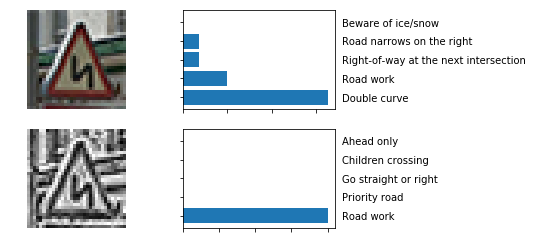

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


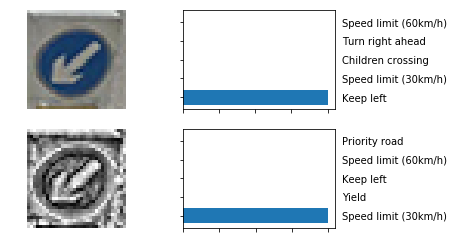

---------------------------------------------------------------------------------------------------

Actual class:  No entry


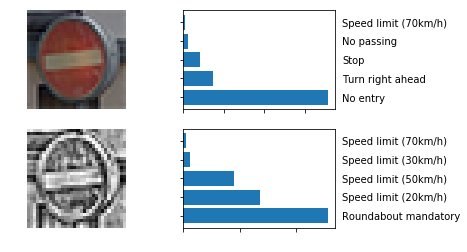

---------------------------------------------------------------------------------------------------

Actual class:  No entry


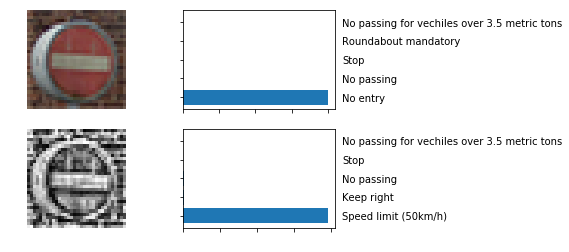

---------------------------------------------------------------------------------------------------

Actual class:  No entry


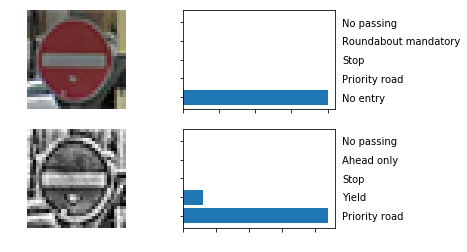

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


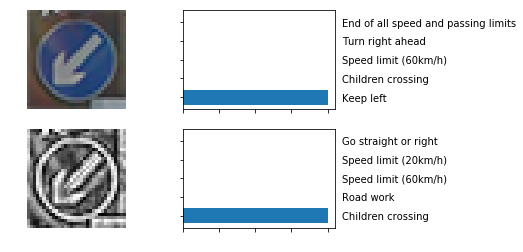

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


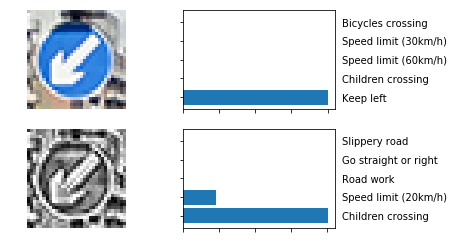

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


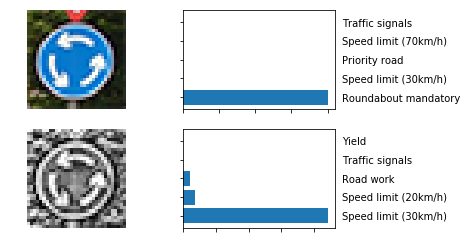

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


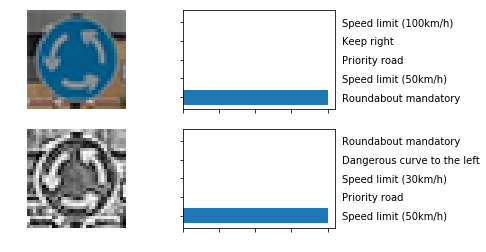

---------------------------------------------------------------------------------------------------

Actual class:  Turn left ahead


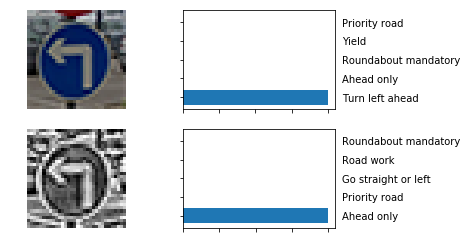

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


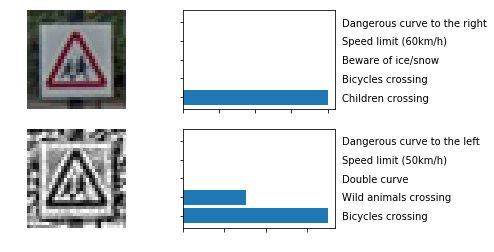

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


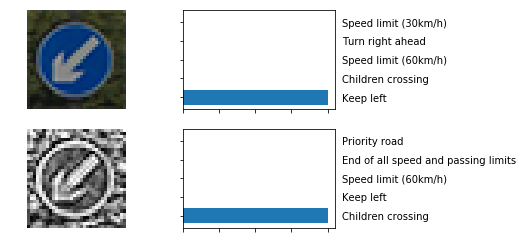

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


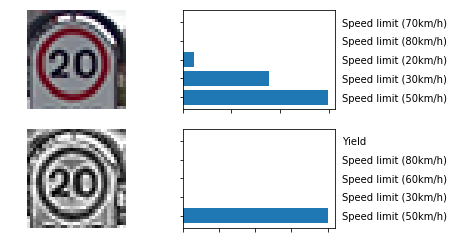

---------------------------------------------------------------------------------------------------

Actual class:  No entry


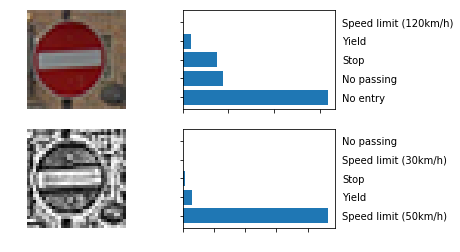

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


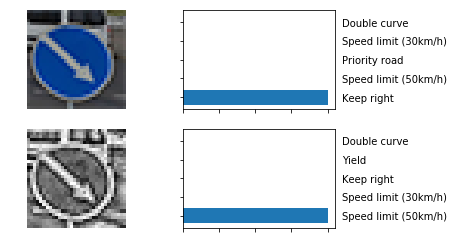

---------------------------------------------------------------------------------------------------

Actual class:  Yield


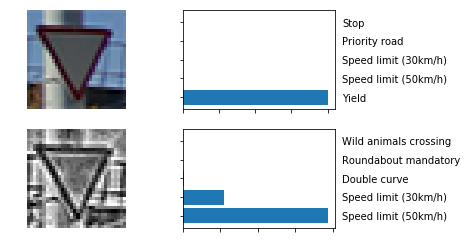

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


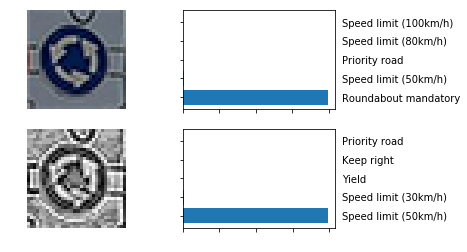

---------------------------------------------------------------------------------------------------

Actual class:  Yield


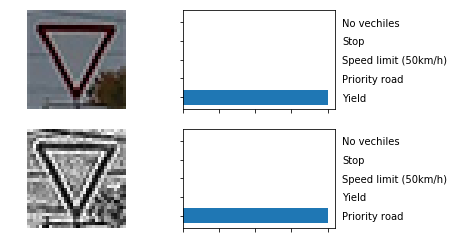

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


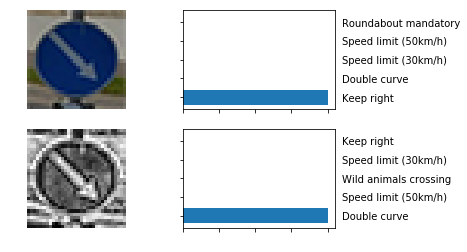

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


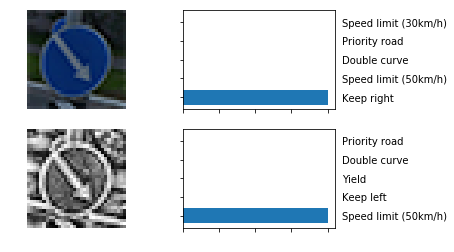

---------------------------------------------------------------------------------------------------

Actual class:  Right-of-way at the next intersection


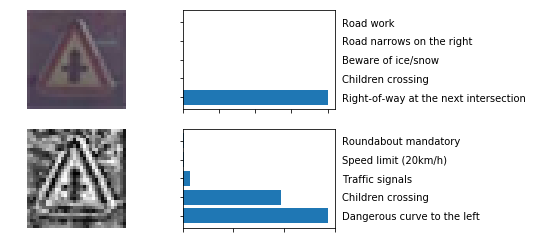

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


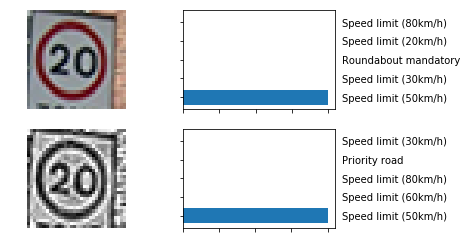

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


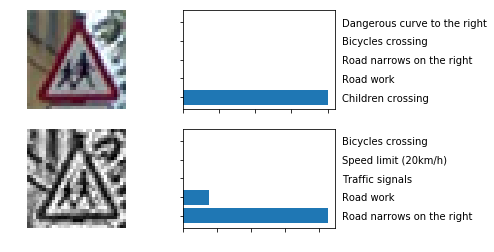

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


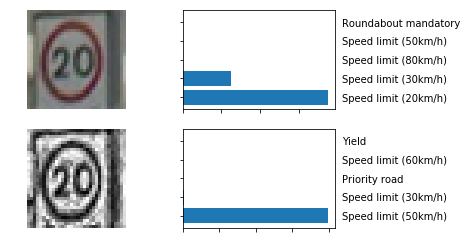

---------------------------------------------------------------------------------------------------

Actual class:  End of all speed and passing limits


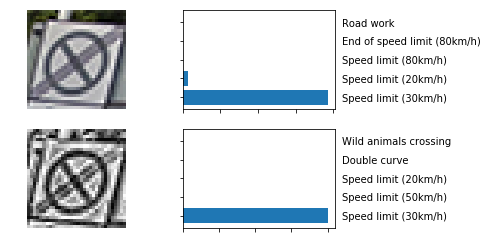

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


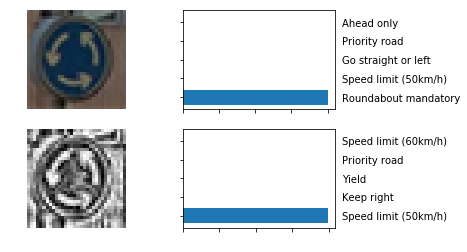

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


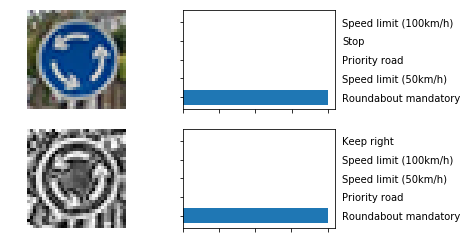

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


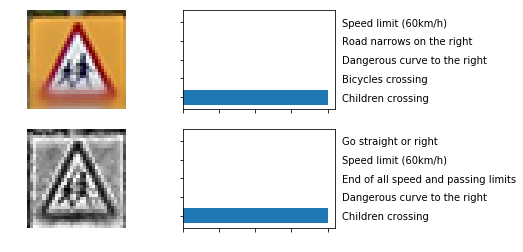

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


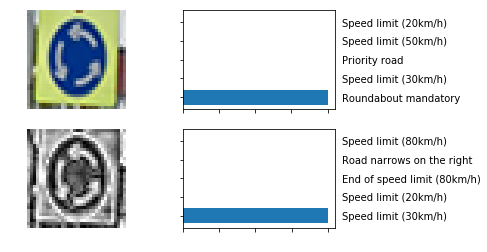

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


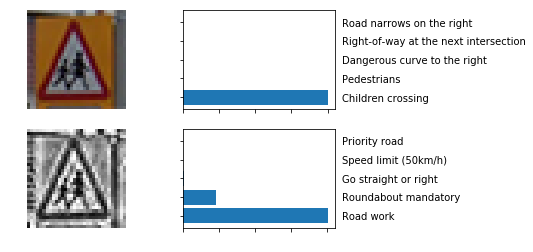

---------------------------------------------------------------------------------------------------

Actual class:  Road narrows on the right


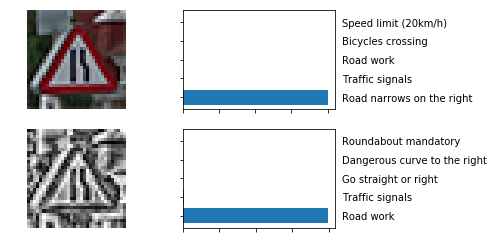

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


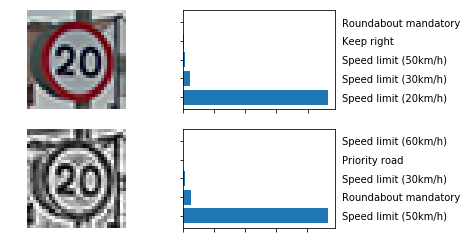

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


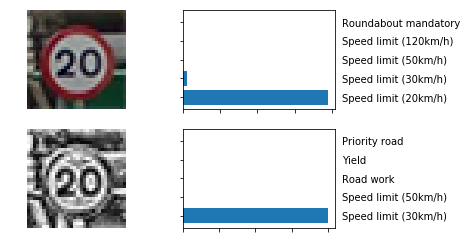

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


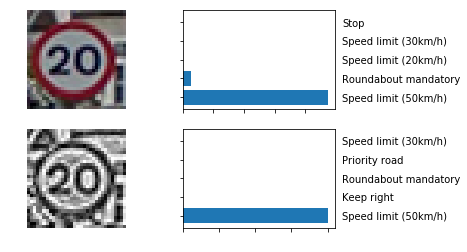

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


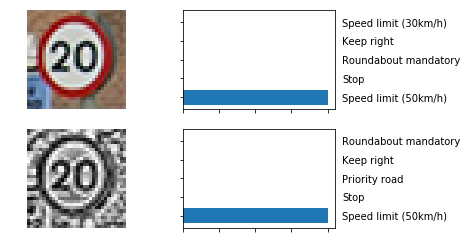

---------------------------------------------------------------------------------------------------



In [111]:
# For every example plot original image, preprocessed image, and model predictions.
for i in range(35):
    print("Actual class: ", signnames[y_custom[i]] if y_custom[i] != 99 else "None")
    plot_image_statistics(ori_predictions,adv_predictions, i)
    print("---------------------------------------------------------------------------------------------------\n")

#  Deepfool Method

In [ ]:
# adv_images_dataset_file="data/adv_images.p"
X_adv,y_adv=load_pickled_data(adv_images_dataset_file,['features','labels'])

parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

batch_iterator=BatchIterator(batch_size=2500)
f=0
for X_batch,y_batch in batch_iterator(X_adv,y_adv):
    f=f+1
    print(f)
    loss,preds,grad=get_loss(parameters,X_batch,y_batch)
    adv_x=fgm(x=X_batch,preds=preds,grad=grad, y=None, eps=0.3, ord=np.inf,clip_min=None, clip_max=None,targeted=False)
    sess=tf.Session()
    adv_image_batch=sess.run(adv_x)
    sess.close()
    if f==1:
        adv_image=adv_image_batch
    else:
        adv_image=np.concatenate((adv_image,adv_image_batch),axis=1)

print(adv_image.shape)
adv_predictions=get_top_k_predictions(parameters,adv_image.reshape(4952,32,32,1),k=1)
ori_predictions=get_top_k_predictions(parameters,X_adv,k=1)
print(adv_predictions.shape[1])
accuracy=100*np.sum(adv_predictions[1]==ori_predictions[1])/adv_predictions.shape[1]
print("Accuracy=",accuracy)

In [19]:
def jacobian_graph(predictions, x, nb_classes):
    """
    Create the Jacobian graph to be ran later in a TF session
    :param predictions: the model's symbolic output (linear output,
        pre-softmax)
    :param x: the input placeholder
    :param nb_classes: the number of classes the model has
    :return:
    """
    # This function will return a list of TF gradients
    list_derivatives = []

    # Define the TF graph elements to compute our derivatives for each class
    for class_ind in range(nb_classes):
        derivatives, = tf.gradients(predictions[:, class_ind], x)
        list_derivatives.append(derivatives)

    return list_derivatives

In [20]:
def model_argmax(sess, x, predictions, samples, feed):
    """
    Helper function that computes the current class prediction
    :param sess: TF session
    :param x: the input placeholder
    :param predictions: the model's symbolic output
    :param samples: numpy array with input samples (dims must match x)
    :param feed: An optional dictionary that is appended to the feeding
             dictionary before the session runs. Can be used to feed
             the learning phase of a Keras model for instance.
    :return: the argmax output of predictions, i.e. the current predicted class
    """
    feed_dict = {x: samples}
    if feed is not None:
        feed_dict.update(feed)
    probabilities = sess.run(predictions, feed_dict)

    if samples.shape[0] == 1:
        return np.argmax(probabilities)
    else:
        return np.argmax(probabilities, axis=1)


In [21]:
def deepfool_attack(sess, x, predictions, logits, grads, sample, nb_candidate,
                    overshoot, max_iter, clip_min, clip_max, feed=None):
    """
    TensorFlow implementation of DeepFool.
    Paper link: see https://arxiv.org/pdf/1511.04599.pdf
    :param sess: TF session
    :param x: The input placeholder
    :param predictions: The model's sorted symbolic output of logits, only the
                       top nb_candidate classes are contained
    :param logits: The model's unnormalized output tensor (the input to
                   the softmax layer)
    :param grads: Symbolic gradients of the top nb_candidate classes, procuded
                 from gradient_graph
    :param sample: Numpy array with sample input
    :param nb_candidate: The number of classes to test against, i.e.,
                         deepfool only consider nb_candidate classes when
                         attacking(thus accelerate speed). The nb_candidate
                         classes are chosen according to the prediction
                         confidence during implementation.
    :param overshoot: A termination criterion to prevent vanishing updates
    :param max_iter: Maximum number of iteration for DeepFool
    :param clip_min: Minimum value for components of the example returned
    :param clip_max: Maximum value for components of the example returned
    :return: Adversarial examples
    """
    import copy

    adv_x = copy.copy(sample)
    # Initialize the loop variables
    iteration = 0
    current = model_argmax(sess, x, logits, adv_x, feed)
    if current.shape == ():
        current = np.array([current])
    w = np.squeeze(np.zeros(sample.shape[1:]))  # same shape as original image
    r_tot = np.zeros(sample.shape)
    original = current  # use original label as the reference

    #_logger.debug("Starting DeepFool attack up to {} iterations".
     #             format(max_iter))
    # Repeat this main loop until we have achieved misclassification
    while (np.any(current == original) and iteration < max_iter):

        #if iteration % 5 == 0 and iteration > 0:
           # _logger.info("Attack result at iteration {} is {}".format(
            #    iteration,
             #   current))
        gradients = sess.run(grads, feed_dict={x: adv_x})
        predictions_val = sess.run(predictions, feed_dict={x: adv_x})
        #print(gradients)
        for idx in range(sample.shape[0]):
            pert = np.inf
            if current[idx] != original[idx]:
                continue
            for k in range(1, nb_candidate):
                w_k = gradients[idx, k,...] - gradients[idx, 0,...]
                f_k = predictions_val[idx, k] - predictions_val[idx, 0]
                # adding value 0.00001 to prevent f_k = 0
                pert_k = (abs(f_k) + 0.00001) / np.linalg.norm(w_k.flatten())
                if pert_k < pert:
                    pert = pert_k
                    w = w_k
            r_i = pert*w/np.linalg.norm(w)
            r_tot[idx, ...] = r_tot[idx, ...] + r_i

        adv_x = np.clip(r_tot + sample, clip_min, clip_max)
        current = model_argmax(sess, x, logits, adv_x, feed)
        if current.shape == ():
            current = np.array([current])
        # Update loop variables
        iteration = iteration + 1

    # need more revision, including info like how many succeed
   # _logger.info("Attack result at iteration {} is {}".format(iteration,
    #             current))
    #_logger.info("{} out of {}".format(sum(current != original),
     #                                  sample.shape[0]) +
      #           " becomes adversarial examples at iteration {}".format(
       #              iteration))
    # need to clip this image into the given range
    adv_x = np.clip((1+overshoot)*r_tot + sample, clip_min, clip_max)
    return adv_x


In [64]:
import matplotlib.gridspec as gridspec
from skimage import io
import os

def plot_image_statistics(ori_predictions,adv_predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
    # Prepare original and preprocessed images
    original = io.imread(os.getcwd() + '/data/Example/' + "example_{0:0>5}".format(i + 1) + '.png')
    preprocessed = X_custom[index].reshape(32, 32)
        
    # Prepare the grid
    pyplot.figure(figsize = (6, 4))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    pyplot.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    pyplot.imshow(original)
    pyplot.axis('off')

    # Plot preprocessed image
    pyplot.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    pyplot.imshow(preprocessed, cmap='gray')
    pyplot.axis('off')
    
    #Plot original predictions
    pyplot.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
    pyplot.barh(np.arange(5)+.5, ori_predictions[0][index], align='center')
    pyplot.yticks(np.arange(5)+.5, signnames[ori_predictions[1][index].astype(int)])
    pyplot.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    

    # Plot adversarial predictions
    pyplot.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
    pyplot.barh(np.arange(5)+.5, adv_predictions[0][index], align='center')
    pyplot.yticks(np.arange(5)+.5, signnames[adv_predictions[1][index].astype(int)])
    pyplot.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    pyplot.show()



parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

# Load images from .png files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.int32)
for i in range(35):
    image = io.imread(os.getcwd() + '/data/Example/' + "example_{0:0>5}".format(i + 1) + '.png')
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

# Provide labels of the captured images:
y_custom = np.array([
    21, # "example_00001"
    39, # "example_00002"
    17, # "example_00003"
    17, # "example_00004"
    17, # "example_00005"
    39, # "example_00006"
    39, # "example_00007"
    40, # "example_00008"
    40, # "example_00009"
    34, # "example_00010"
    28, # "example_00011"
    39, # "example_00012"
    0, # "example_00013"
    17, # "example_00014"
    38, # "example_00015"
    13, # "example_00016"
    40, # "example_00017"
    13, # "example_00018"
    38, # "example_00019"
    38, # "example_00020"
    11, # "example_00021"
    0, # "example_00022"
    28, # "example_00023"
    0, # "example_00024"
    32, # "example_00028"
    40, # "example_00029"
    28, # "example_00030"
    40, # "example_00031"
    40, # "example_00032"
    28, # "example_00033"
    24, # "example_00034"
    0, # "example_00035"
    0, # "example_00036"
    0, # "example_00037"
    0 # "example_00038"
])

# Preprocess and get predictions based on the current model
X_custom, _ = preprocess_dataset(X_custom)


paths = Paths(parameters)
    
    # Build the graph

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x = tf.placeholder(tf.float32, shape = (None, parameters.image_size[0], parameters.image_size[1], 1))
    is_training = tf.constant(False)
        
    with tf.variable_scope(paths.var_scope):
        
        adv_logits=model_pass(tf_x, parameters, is_training)
        adv_preds = tf.reshape(tf.nn.top_k(adv_logits, k=10)[0],[-1, 10])
        adv_grads = tf.stack(jacobian_graph(adv_preds, tf_x, 10), axis=1)
            
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        tf.train.Saver().restore(sess, paths.model_path)
        adv_image=deepfool_attack(sess, tf_x, adv_preds, adv_logits, adv_grads, X_custom, nb_candidate=10,overshoot=0.02, max_iter=50, clip_min=0, clip_max=1, feed=None)

print(adv_image.shape)
adv_predictions=get_top_k_predictions(parameters,adv_image,k=1)
ori_predictions=get_top_k_predictions(parameters,X_custom)


Preprocessing dataset with 35 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
(35, 32, 32, 1)
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
[[ 25.]
 [  1.]
 [ 33.]
 [  9.]
 [ 40.]
 [ 33.]
 [ 28.]
 [  1.]
 [  2.]
 [ 13.]
 [ 29.]
 [ 28.]
 [  1.]
 [  9.]
 [  2.]
 [  1.]
 [  2.]
 [ 12.]
 [ 21.]
 [  2.]
 [ 28.]
 [  1.]
 [ 24.]
 [  1.]
 [  0.]
 [  2.]
 [  2.]
 [ 24.]
 [  1.]
 [ 11.]
 [ 26.]
 [  2.]
 [  1.]
 [ 40.]
 [  0.]]


Actual class:  Double curve


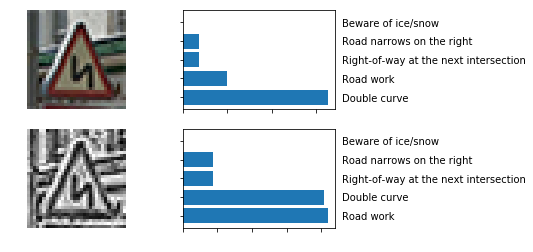

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


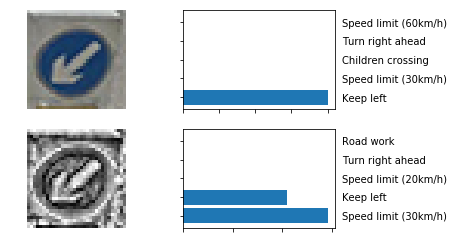

---------------------------------------------------------------------------------------------------

Actual class:  No entry


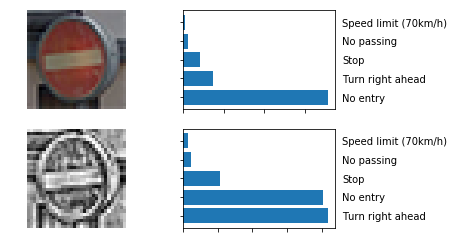

---------------------------------------------------------------------------------------------------

Actual class:  No entry


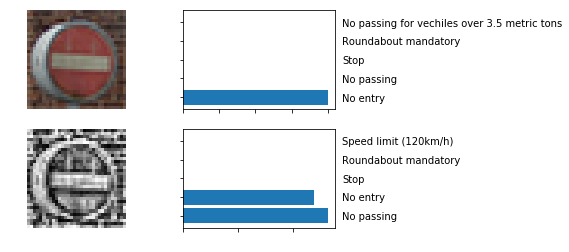

---------------------------------------------------------------------------------------------------

Actual class:  No entry


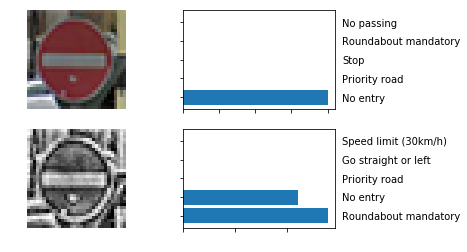

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


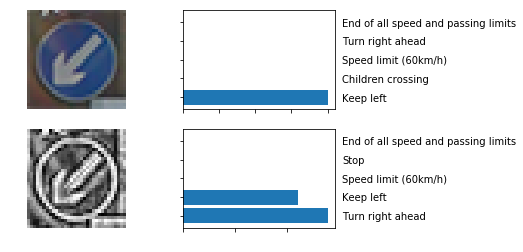

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


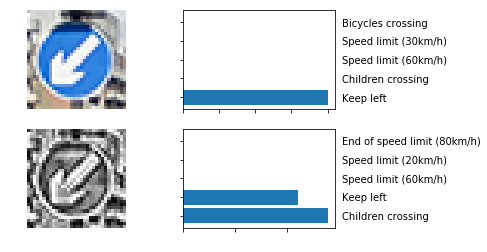

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


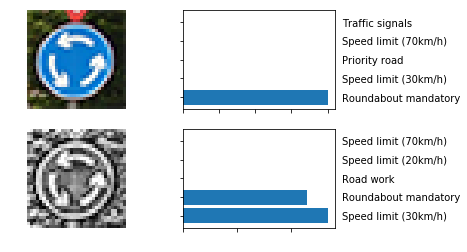

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


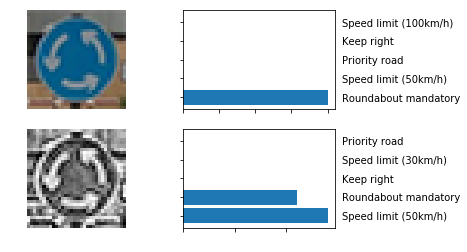

---------------------------------------------------------------------------------------------------

Actual class:  Turn left ahead


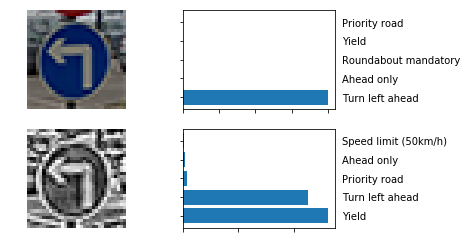

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


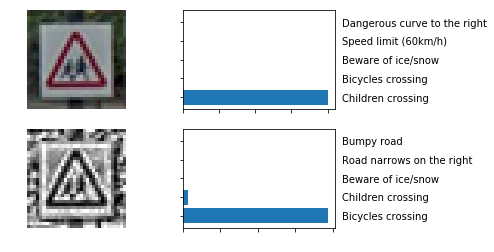

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


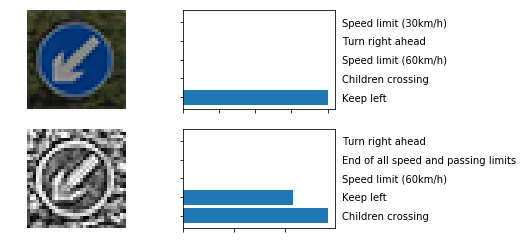

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


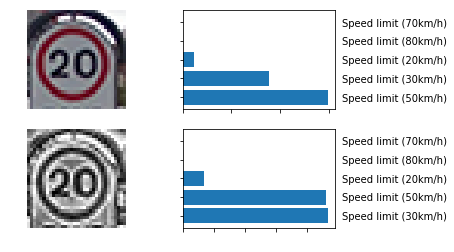

---------------------------------------------------------------------------------------------------

Actual class:  No entry


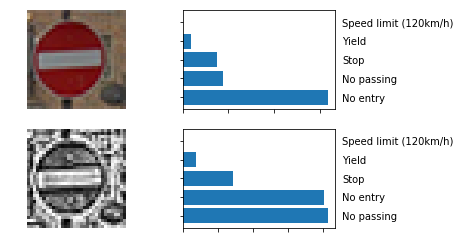

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


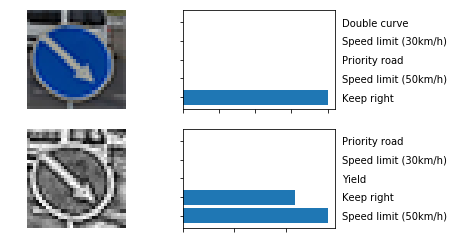

---------------------------------------------------------------------------------------------------

Actual class:  Yield


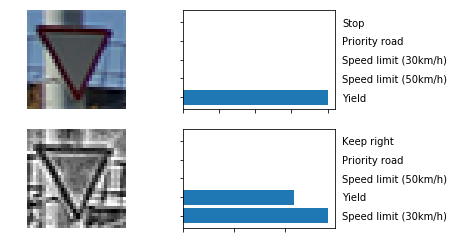

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


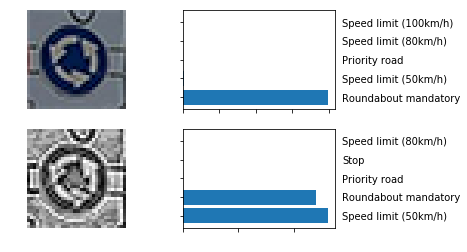

---------------------------------------------------------------------------------------------------

Actual class:  Yield


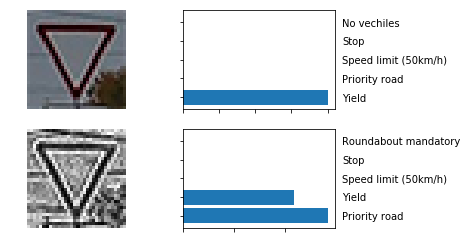

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


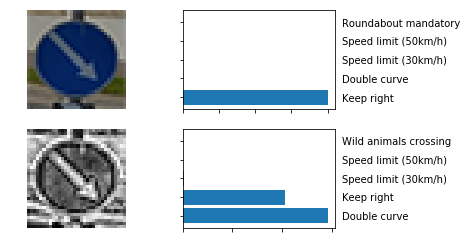

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


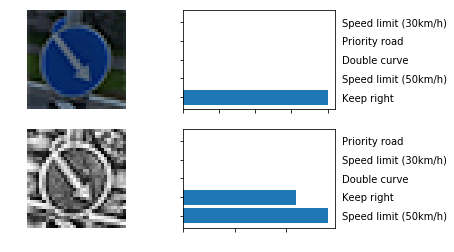

---------------------------------------------------------------------------------------------------

Actual class:  Right-of-way at the next intersection


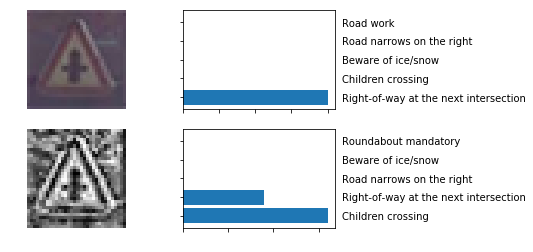

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


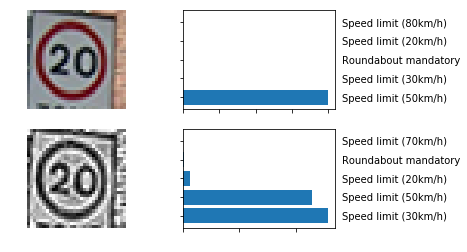

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


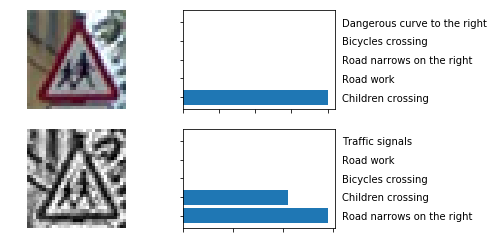

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


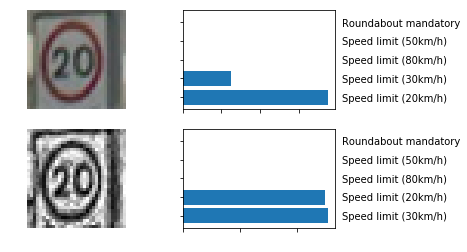

---------------------------------------------------------------------------------------------------

Actual class:  End of all speed and passing limits


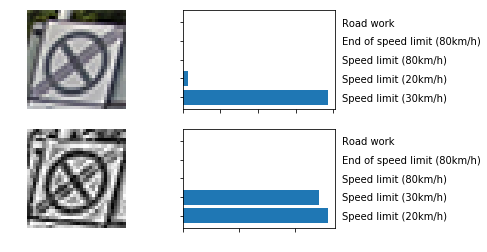

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


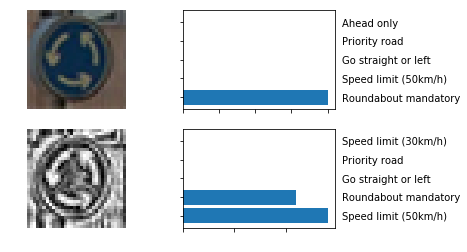

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


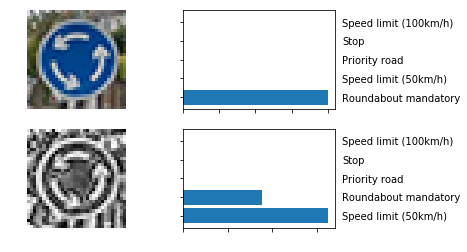

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


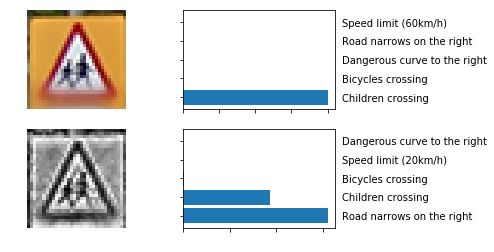

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


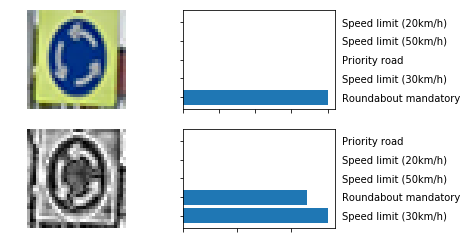

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


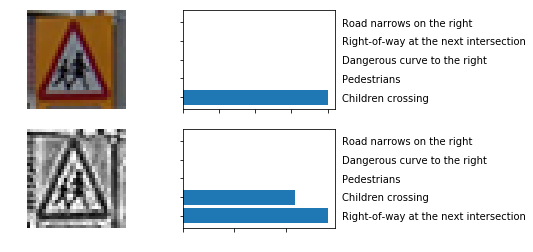

---------------------------------------------------------------------------------------------------

Actual class:  Road narrows on the right


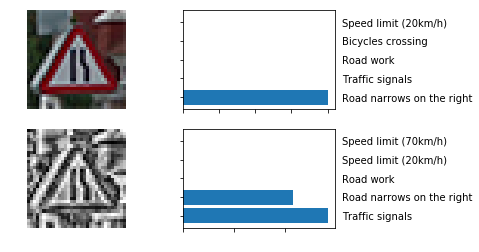

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


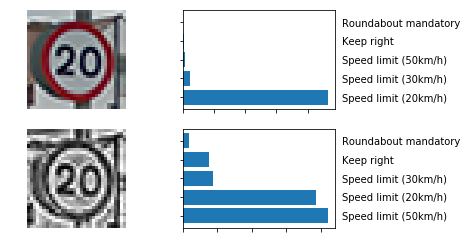

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


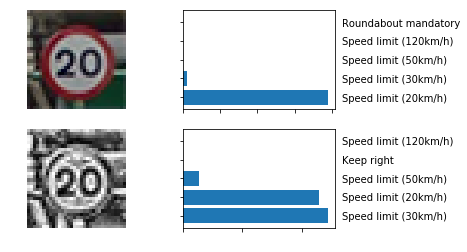

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


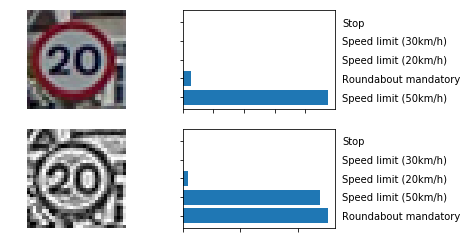

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


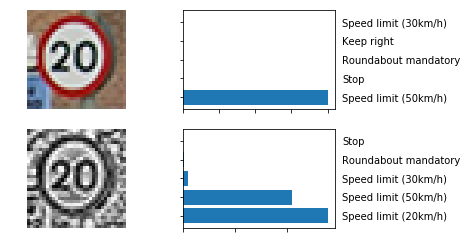

---------------------------------------------------------------------------------------------------



In [116]:
# For every example plot original image, preprocessed image, and model predictions.
for i in range(35):
    print("Actual class: ", signnames[y_custom[i]] if y_custom[i] != 99 else "None")
    plot_image_statistics(ori_predictions, adv_predictions, i)
    print("---------------------------------------------------------------------------------------------------\n")

In [78]:

adv_images_dataset_file="data/adv_images.p"
X_adv,y_adv=load_pickled_data(adv_images_dataset_file,['features','labels'])


parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

paths = Paths(parameters)

# Build the graph
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x = tf.placeholder(tf.float32, shape = (None, parameters.image_size[0], parameters.image_size[1], 1))
    is_training = tf.constant(False)
        
    with tf.variable_scope(paths.var_scope):
        
        adv_logits=model_pass(tf_x, parameters, is_training)
        adv_preds = tf.reshape(tf.nn.top_k(adv_logits, k=10)[0],[-1, 10])
        adv_grads = tf.stack(jacobian_graph(adv_preds, tf_x, 10), axis=1)
            
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        tf.train.Saver().restore(sess, paths.model_path)
        batch_iterator=BatchIterator(batch_size=128)
        f=0
        for X_batch,y_batch in batch_iterator(X_adv,y_adv):
            f=f+1
            print(f)
            adv_image_batch=deepfool_attack(sess, tf_x, adv_preds, adv_logits, adv_grads, X_batch, nb_candidate=10,overshoot=0.02, max_iter=50, clip_min=0, clip_max=1, feed=None)
            if f==1:
                adv_image=adv_image_batch
            else:
                adv_image=np.concatenate((adv_image,adv_image_batch),axis=0)

print(adv_image.shape)
adv_predictions=get_top_k_predictions(parameters,adv_image,k=1)
ori_predictions=get_top_k_predictions(parameters,X_adv,k=1)
print(adv_predictions.shape[1])
accuracy=100*np.sum(adv_predictions[1]==ori_predictions[1])/adv_predictions.shape[1]

INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(4952, 32, 32, 1)
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
INFO:tensorflow:Restoring parameters from C:\Users\wasta\Desktop\TSC/models/k5d32p0.9_k5d64p0.8_k5d128p0.7_fc1024p0.5_no-lrdec_l2/model.ckpt
4952


import random

train_preprocessed_file="data/train_processed.p"
X_train,y_train=load_pickled_data(train_preprocessed_file,['features','labels'])

index=random.randint(0,len(X_train))
X_adv=[X_train[index]]
y_adv=[y_train[index]]
adv_len=0.1*len(X_train)

for i in range(int(adv_len)):
    index=random.randint(0,len(X_train))
    X_adv=np.concatenate((X_adv,[X_train[index]]),axis=0)
    y_adv=np.concatenate((y_adv,[y_train[index]]),axis=0)
    
print(y_adv.shape)
print(X_adv.shape)

import pickle

adv_dataset_file="data/adv_images.p"
pickle.dump({
    "features":X_adv,
    "labels":y_adv
},open(adv_dataset_file,"wb"))
print("adv_images saved")

In [80]:
print(adv_image.shape)
print(adv_image_batch.shape)
accuracy=100*np.sum(adv_predictions[1]==ori_predictions[1])/adv_predictions.shape[1]
print(accuracy)

(4952, 32, 32, 1)
(88, 32, 32, 1)
3.1098546042
